In [1]:
#imports
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from xgboost import XGBRegressor
import joblib
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import time
from datetime import datetime

# Load and Combine Seasons

1. **Base URL and Seasons**: It defines a base URL to access raw data from a GitHub repository and specifies the seasons of interest (2024-25, 2023-24, 2022-23, 2021-22).

2. **Model Name**: It sets a model name (`MODEL_NAME`) that presumably refers to a pre-trained model file.

3. **Loading Season Data**: The function `load_season_data(season)` performs the following tasks:
   - Initializes a dictionary `data` to store data for various categories (players, player IDs, fixtures, teams, and player history).
   - Defines a dictionary of file names corresponding to each category.
   - Iterates over the file names, reading the CSV files from the specified season's folder using the base URL. 
   - For the "teams" category, it only loads specific columns (`id` and `name`).
   - Adds a new column, `season`, to each dataframe to indicate the season from which the data is sourced.

4. **Loading All Seasons Data**: The function `load_all_seasons_data(seasons)`:
   - Initializes a dictionary `all_data` to hold lists for each data category.
   - Calls `load_season_data(season)` for each specified season to load the data.
   - Appends the data from each season to the respective lists in `all_data`.
   - Finally, concatenates the lists into a single dataframe for each category, ignoring index conflicts.

5. **Combining Data**: After defining the functions, the code calls `load_all_seasons_data(seasons)` to load and combine data from all specified seasons.

6. **Accessing Combined Data**: It stores the combined dataframes for players, fixtures, player IDs, player history, and teams in separate variables for further analysis or processing.

In summary, the section fetches and organizes fantasy football data from multiple seasons into structured dataframes for subsequent use.

In [2]:
base_url = 'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/'
seasons = ['2024-25', '2023-24', '2022-23', '2021-22']
MODEL_NAME = 'FPL_XGboost_20241016.joblib'

def load_season_data(season):
    data = {}
    files = {
        'players': 'players_raw.csv',
        'player_ids': 'player_idlist.csv',
        'fixtures': 'fixtures.csv',
        'teams': 'teams.csv',
        'player_history': 'gws/merged_gw.csv'
    }
    
    for key, file in files.items():
        if key == 'teams':
            data[key] = pd.read_csv(f'{base_url}{season}/{file}', usecols=['id', 'name'])
        else:
            data[key] = pd.read_csv(f'{base_url}{season}/{file}')
        
        data[key]['season'] = season
    
    return data

def load_all_seasons_data(seasons):
    all_data = {key: [] for key in ['players', 'player_ids', 'fixtures', 'teams', 'player_history']}
    
    for season in seasons:
        season_data = load_season_data(season)
        for key in all_data:
            all_data[key].append(season_data[key])
    
    return {key: pd.concat(value, ignore_index=True) for key, value in all_data.items()}

# Load and combine data for all seasons
combined_data = load_all_seasons_data(seasons)

# Access the combined dataframes
players = combined_data['players']
fixtures = combined_data['fixtures']
player_ids = combined_data['player_ids']
player_history = combined_data['player_history']
teams = combined_data['teams']

# Clean Data and Prep for Model

### 1. **Creating Unique IDs**
- **Function `create_unique_ids(player_ids, teams)`**: 
  - Generates unique identifiers for players and teams.
  - Combines player first and second names to create a full name and drops duplicates to create a unique player dataframe (`players_unique`).
  - Creates a unique ID for each player based on their index.
  - Drops duplicates from the teams dataframe and creates a unique ID for each team.

### 2. **Merging Unique IDs**
- **Function `merge_unique_ids(players, player_history, teams, players_unique, teams_unique, fixtures)`**: 
  - Merges unique player IDs into player data and player history based on names.
  - Merges unique team IDs into team data and renames columns to better reflect the data.
  - Merges team IDs into players and player history based on their respective teams for the season.
  - Adds unique team IDs to fixtures and creates a combined `game` identifier for easier analysis.

### 3. **Cleaning Player Data**
- **Function `clean_players(df)`**: 
  - Cleans player data by converting certain columns to numeric types, filling missing values, and dropping unnecessary columns.
  - Renames the full name column for consistency.

### 4. **Cleaning Player History Data**
- **Function `clean_player_history(df)`**: 
  - Cleans player history data by dropping rows without unique player IDs and filling missing values in key columns.
  - Converts columns to appropriate data types and calculates cumulative statistics (points, minutes) and averages for performance metrics.

### 5. **Formatting Columns**
- **Function `format_columns(df)`**: 
  - Converts specific columns to strings or numeric types and rounds numeric values for consistency.

### 6. **Calculating Rolling Averages**
- **Functions `calculate_overall_rolling_averages(df, window=5)` and `calculate_opponent_rolling_difficulty(df, window=5)`**: 
  - Calculate rolling averages for goals scored and conceded for teams over a specified window (default is 5).
  - Determine opponent difficulty by calculating rolling averages of team difficulties.

### 7. **Merging Rolling Averages**
- **Function `merge_rolling_avgs(df, overall_averages, fixture_difficulty)`**: 
  - Merges calculated rolling averages and difficulty metrics into the player history dataframe for comprehensive analysis.

### 8. **Main Processing Function**
- **Function `process_data(player_ids, teams, players, player_history, fixtures)`**: 
  - Integrates all previous functions to clean and process data.
  - Creates unique IDs, merges them, cleans player and player history data, calculates rolling averages, and ensures that required columns are present in the final output.
  - Returns the processed dataframes for players, player history, teams, fixtures, unique IDs, required columns, overall averages, and fixture difficulty.

### 9. **Usage**
- The final comment shows how to call the `process_data` function with the relevant dataframes to perform the entire data processing workflow.

Overall, this section efficiently organizes and prepares the fantasy football data for analysis by generating unique identifiers, cleaning data, calculating performance metrics, and ensuring that all necessary information is readily available.

In [3]:
def create_unique_ids(player_ids, teams):
    # Create unique ID for each player
    player_ids['name'] = player_ids['first_name'] + ' ' + player_ids['second_name']
    players_unique = player_ids.drop(['id', 'season'], axis=1).drop_duplicates()
    players_unique['PlayerUniqueID'] = players_unique.index

    # Create unique ID for each team
    teams_unique = teams.drop(['id', 'season'], axis=1).drop_duplicates().reset_index(drop=True)
    teams_unique['TeamUniqueID'] = teams_unique.index + 1

    return players_unique, teams_unique

def merge_unique_ids(players, player_history, teams, players_unique, teams_unique, fixtures):
    # Merge player unique IDs
    players = players.merge(players_unique, on=['first_name', 'second_name'], how='left')
    player_history = player_history.merge(players_unique, on='name', how='left')

    # Merge team unique IDs
    teams = teams.merge(teams_unique, on='name', how='left')
    teams.rename(columns={'name': 'team_name'}, inplace=True)
    teams_opponent = teams.rename(columns={'team_name': 'team_name_oppo', 'TeamUniqueID': 'TeamUniqueID_oppo'})

    # Merge team IDs to players and player_history
    players = players.merge(teams, left_on=['team', 'season'], right_on=['id', 'season'], how='left')
    player_history = player_history.merge(teams, left_on=['team', 'season'], right_on=['team_name', 'season'], how='left')
    player_history = player_history.merge(teams_opponent, left_on=['opponent_team', 'season'], right_on=['id', 'season'], how='left')
    player_history.drop(['id_x', 'id_y'], axis=1, inplace=True)
    
    #add unique team ids to fixtures
    fixtures = fixtures.merge(teams, left_on=['team_h','season'], right_on=['id','season'], how='left')
    fixtures = fixtures.merge(teams_opponent, left_on=['team_a','season'], right_on=['id','season'], how='left')
    fixtures.drop(['id_x','id_y'],axis = 1,inplace=True)

    #add in column for season and gameweek
    fixtures['game']=fixtures['season'].str.replace('-','') + fixtures['event'].astype(str).str.zfill(2)

    return players, player_history, teams, fixtures

def clean_players(df):
    replace_cols = ['chance_of_playing_next_round', 'chance_of_playing_this_round', 'corners_and_indirect_freekicks_order',
                    'direct_freekicks_order', 'penalties_order', 'clean_sheets_per_90', 'expected_assists',
                    'expected_assists_per_90', 'expected_goal_involvements', 'expected_goal_involvements_per_90',
                    'expected_goals', 'expected_goals_conceded', 'expected_goals_conceded_per_90', 'expected_goals_per_90',
                    'form_rank', 'form_rank_type', 'goals_conceded_per_90', 'now_cost_rank', 'now_cost_rank_type',
                    'points_per_game_rank', 'points_per_game_rank_type', 'saves_per_90', 'selected_rank', 'selected_rank_type',
                    'starts', 'starts_per_90']

    drop_cols = ['corners_and_indirect_freekicks_text', 'direct_freekicks_text', 'news', 'news_added', 'penalties_text',
                 'photo', 'special', 'squad_number']

    df['form'] = df['form'].astype(float)
    df['total_points'] = df['total_points'].astype(float)
    df['minutes'] = df['minutes'].astype(float)
    df['cost'] = df['now_cost'] / 10
    df['name'] = df['first_name'] + ' ' + df['second_name']

    df[replace_cols] = df[replace_cols].fillna(0).replace('None', 0)
    df[replace_cols] = df[replace_cols].apply(pd.to_numeric, errors='coerce')
    df.drop(columns=drop_cols, inplace=True)

    return df

def clean_player_history(df):
    df.dropna(subset=["PlayerUniqueID"], inplace=True)
    
    replace_cols = ['expected_assists', 'expected_goal_involvements', 'expected_goals', 'expected_goals_conceded', 'starts']
    df[replace_cols] = df[replace_cols].fillna(0)

    for col in ['influence', 'creativity', 'threat', 'ict_index']:
        df[col] = df[col].astype(float)

    df['cost'] = df['value'] / 10
    df['game'] = df['season'].str.replace('-', '') + df['GW'].astype(str).str.zfill(2)
    df['was_home'] = df['was_home'].astype(int)

    df = df.sort_values(by=['PlayerUniqueID', 'season', 'GW'])
    df['cumulative_points'] = df.groupby(['PlayerUniqueID', 'season'])['total_points'].cumsum()
    df['cumulative_minutes'] = df.groupby(['PlayerUniqueID', 'season'])['minutes'].cumsum()
    df['ppm'] = (df['cumulative_points'] / df['cumulative_minutes']).fillna(0).replace([np.inf, -np.inf], 0).round(5)
    df['points_per_cost'] = (df['cumulative_points'] / df['cost']).round(5)
    df['rolling_avg_points'] = df.groupby('PlayerUniqueID')['total_points'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True).round(5)

    df['position'] = df['position'].map({'GK': 1, 'DEF': 2, 'MID': 3, 'FWD': 4})
    df.dropna(subset=['position'], inplace=True)

    return df

def format_columns(df):
    strings = ['position', 'PlayerUniqueID', 'TeamUniqueID', 'TeamUniqueID_oppo', 'game']
    nums = ['xP', 'assists', 'clean_sheets', 'creativity', 'expected_assists',
            'expected_goal_involvements', 'expected_goals', 'expected_goals_conceded', 'goals_conceded',
            'goals_scored', 'influence', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved',
            'red_cards', 'saves', 'selected', 'starts', 'threat', 'transfers_balance', 'cost', 'was_home',
            'yellow_cards', 'cumulative_points', 'cumulative_minutes', 'ppm', 'rolling_avg_points',
            'rolling_avg_goals_scored', 'rolling_avg_goals_conceded', 'rolling_team_difficulty']

    df[strings] = df[strings].astype(str)
    df[nums] = df[nums].round(5)
    
    return df

def calculate_overall_rolling_averages(df, window=5):
    team_data = pd.concat([
        df[['game', 'TeamUniqueID', 'team_h_score', 'team_a_score']].rename(columns={'TeamUniqueID': 'team_id', 'team_h_score': 'goals_scored', 'team_a_score': 'goals_conceded'}),
        df[['game', 'TeamUniqueID_oppo', 'team_a_score', 'team_h_score']].rename(columns={'TeamUniqueID_oppo': 'team_id', 'team_a_score': 'goals_scored', 'team_h_score': 'goals_conceded'})
    ])
    
    team_data = team_data.sort_values(['team_id', 'game'])
    
    team_data['rolling_avg_goals_scored'] = team_data.groupby('team_id')['goals_scored'].rolling(window=window, min_periods=1).mean().reset_index(0, drop=True)
    team_data['rolling_avg_goals_conceded'] = team_data.groupby('team_id')['goals_conceded'].rolling(window=window, min_periods=1).mean().reset_index(0, drop=True)
    
    return team_data

def calculate_opponent_rolling_difficulty(df, window=5):
    team_data_diff = pd.concat([
        df[['game', 'TeamUniqueID', 'team_h_difficulty']].rename(columns={'TeamUniqueID': 'team_id', 'team_h_difficulty': 'team_difficulty'}),
        df[['game', 'TeamUniqueID_oppo', 'team_a_difficulty']].rename(columns={'TeamUniqueID_oppo': 'team_id', 'team_a_difficulty': 'team_difficulty'})
    ])
    
    team_data_diff = team_data_diff.sort_values(['team_id', 'game'])
    team_data_diff['rolling_team_difficulty'] = team_data_diff.groupby('team_id')['team_difficulty'].rolling(window=window, min_periods=1).mean().reset_index(0, drop=True)
    
    return team_data_diff

def merge_rolling_avgs(df, overall_averages, fixture_difficulty):
    df = pd.merge(df, overall_averages[['game', 'team_id', 'rolling_avg_goals_scored', 'rolling_avg_goals_conceded']],
                  left_on=['game', 'TeamUniqueID'], right_on=['game', 'team_id'], how='left')
    df.drop(['team_id'], axis=1, inplace=True)

    df = pd.merge(df, fixture_difficulty[['game', 'team_id', 'team_difficulty', 'rolling_team_difficulty']],
                  left_on=['game', 'TeamUniqueID'], right_on=['game', 'team_id'], how='left')
    df.drop(['team_id'], axis=1, inplace=True)
    
    return df

def process_data(player_ids, teams, players, player_history, fixtures):
    players_unique, teams_unique = create_unique_ids(player_ids, teams)
    players, player_history, teams, fixtures = merge_unique_ids(players, player_history, teams, players_unique, teams_unique, fixtures)
    
    players = clean_players(players)
    player_history = clean_player_history(player_history)
    #clean_player_history function has things in it out of order to the rolling and merge functions
    
    overall_averages = calculate_overall_rolling_averages(fixtures)
    fixture_difficulty = calculate_opponent_rolling_difficulty(fixtures)
    
    player_history = merge_rolling_avgs(player_history, overall_averages, fixture_difficulty)
    
    player_history=format_columns(player_history)
    
    player_history['TeamUniqueID'] = player_history['TeamUniqueID'].astype(str)
    players['TeamUniqueID'] = players['TeamUniqueID'].astype(str)
    
    required_columns = [
        'position', 'xP', 'assists', 'clean_sheets', 'creativity', 'expected_assists',
        'expected_goal_involvements', 'expected_goals', 'expected_goals_conceded', 'goals_conceded', 
        'goals_scored', 'influence', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved', 
        'red_cards', 'saves', 'starts', 'threat', 'transfers_balance', 'cost', 'was_home',
        'yellow_cards', 'PlayerUniqueID', 'TeamUniqueID', 'TeamUniqueID_oppo', 'cumulative_points',
        'cumulative_minutes', 'ppm', 'rolling_avg_points', 'rolling_avg_goals_scored', 
        'rolling_avg_goals_conceded', 'rolling_team_difficulty', 'game'
    ]
    
    for col in required_columns:
        if col not in player_history.columns:
            player_history[col] = np.nan
    #some of these columns are exported for use later on
    return players, player_history, teams, fixtures, players_unique, required_columns, overall_averages, fixture_difficulty

# Usage
# players, player_history, teams, fixtures = process_data(player_ids, teams, players, player_history, fixtures)

In [4]:
players, player_history, teams, fixtures, players_unique, required_columns, overall_averages, fixture_difficulty = process_data(player_ids, teams, players, player_history, fixtures)

# Run The Model

1. **prepare_data(player_history, features, target)**:
   - Identifies numeric and categorical features in the player history data.
   - Imputes missing values in numeric features with the mean.
   - Converts categorical features to the appropriate data type.
   - Ensures that 'game' and 'position' columns are treated as ordered categorical data.

2. **add_season_weights(player_history)**:
   - Extracts the year from the 'season' column and converts it to numeric.
   - Computes a season weight based on the range of seasons present, dropping any rows with NaN values.

3. **train_model_with_grid_search(X_train, y_train, sample_weights=None)**:
   - Defines a parameter grid for an XGBoost regressor.
   - Uses grid search with cross-validation and early stoppage to find the best hyperparameters.
   - Implements a custom scoring function based on mean absolute error.

4. **update_model(model, X_train, y_train, X_test, y_test, sample_weights=None)**:
   - Updates the existing model with new training data.
   - Computes and prints the mean absolute error before and after the update.

5. **evaluate_model(model, X_test, y_test)**:
   - Evaluates the model using mean absolute error and R-squared metrics.

6. **plot_feature_importance(model, features)**:
   - Visualizes the importance of features used in the model.

7. **save_model(model, filename)**:
   - Saves the trained model to a specified filename.

8. **load_model(filename)**:
   - Loads a previously saved model from a file, returning `None` if not found.

9. **dynamic_model_training_with_updates(player_history, features, target, current_season_games)**:
   - Prepares the player history data and adds season weights.
   - Loads the latest model and processes each game week for the current season.
   - For each game week, it either trains a new model or updates the existing one.
   - Evaluates the model, collects predictions, and calculates overall performance metrics.
   - Plots feature importance and saves the updated model.

### Overall Workflow:
The section prepares player data, trains or updates a predictive model for game outcomes, evaluates its performance, and saves the model for future use. Each game week is processed in a loop, allowing for dynamic updates to the model based on the most recent data.

In [5]:
def prepare_data(player_history, features, target):
    #print(f"Shape of player_history before prepare_data: {player_history.shape}")
    
    # Identify numeric and categorical features
    numeric_features = player_history[features].select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = player_history[features].select_dtypes(include=[object]).columns.tolist()

    # Impute numeric features
    numeric_imputer = SimpleImputer(strategy='mean')
    player_history[numeric_features] = numeric_imputer.fit_transform(player_history[numeric_features])

    # Convert object columns to 'category' dtype
    for col in categorical_features:
        player_history[col] = player_history[col].astype('category')
        
    # Ensure 'game' column is ordered
    if 'game' in player_history.columns:
        player_history['game'] = pd.Categorical(player_history['game'], ordered=True)

    # Ensure 'position' column is ordered if applicable
    if 'position' in player_history.columns:
        player_history['position'] = pd.Categorical(player_history['position'], 
                                                    categories=['GK', 'DEF', 'MID', 'FWD'], 
                                                    ordered=True)
    
    #print(f"Shape of player_history after prepare_data: {player_history.shape}")
    return player_history

def add_season_weights(player_history):
    #print(f"Shape of player_history before add_season_weights: {player_history.shape}")
    
    # Extract the year from the 'season' column
    player_history['season'] = player_history['season'].str.split('-').str[0]

    # Convert 'season' to numeric
    player_history['season'] = pd.to_numeric(player_history['season'], errors='coerce')
    
    # Drop any rows where 'season' is NaN
    player_history = player_history.dropna(subset=['season'])
    
    current_season = player_history['season'].max()
    min_season = player_history['season'].min()
    
    player_history['season_weight'] = (player_history['season'] - min_season + 1) / (current_season - min_season + 1)
    
    #print(f"Shape of player_history after add_season_weights: {player_history.shape}")
    return player_history

def train_model_with_grid_search(X_train, y_train, sample_weights=None):
    #print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")
    #if sample_weights is not None:
        #print(f"Shape of sample_weights: {sample_weights.shape}")
        
    # Try to detect if GPU is available
    try:
        import xgboost as xgb
        gpu_available = len(xgb.device_enumeration()) > 0
        tree_method = 'gpu_hist' if gpu_available else 'hist'
    except:
        tree_method = 'hist'
    
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7],
        'reg_alpha': [0.5, 1, 2],
        'reg_lambda': [0.5, 1, 2],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'enable_categorical': [True],
        'tree_method': [tree_method]
    }
        
    xgb = XGBRegressor(random_state=42,
                       #early_stopping_rounds=10, 
                       n_jobs=-1# Use all CPU cores
                      )
    
    def custom_scorer(y_true, y_pred, sample_weight=None):
        y_true = pd.to_numeric(y_true, errors='coerce')
        y_pred = pd.to_numeric(y_pred, errors='coerce')
        if sample_weight is not None:
            sample_weight = pd.to_numeric(sample_weight, errors='coerce')
        
        mask = ~(np.isnan(y_true) | np.isnan(y_pred))
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        if sample_weight is not None:
            sample_weight = sample_weight[mask]
        
        return -mean_absolute_error(y_true, y_pred, sample_weight=sample_weight)
    
    scorer = make_scorer(custom_scorer, greater_is_better=False)
    
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                               scoring=scorer, cv=3, n_jobs=-1, verbose=0)
    
    grid_search.fit(X_train, y_train, sample_weight=sample_weights)
    
    print("Best parameters found: ", grid_search.best_params_)
    print("Best score: ", -grid_search.best_score_)
    
    return grid_search.best_estimator_

def update_model(model, X_train, y_train, X_test, y_test, sample_weights=None):
    print("Updating model...")
    #print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")
    #print(f"Shape of X_test: {X_test.shape}, Shape of y_test: {y_test.shape}")
    
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    print(f"MAE before update: {mae}")
    
    X_train_updated = pd.concat([X_train, X_test])
    y_train_updated = pd.concat([y_train, y_test])
    
    if sample_weights is not None:
        sample_weights_updated = np.concatenate([sample_weights, np.ones(len(X_test))])
    else:
        sample_weights_updated = None
    
    model.fit(X_train_updated, y_train_updated, sample_weight=sample_weights_updated)
    
    predictions_after = model.predict(X_test)
    mae_after = mean_absolute_error(y_test, predictions_after)
    print(f"MAE after update: {mae_after}")
    
    return model

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return mae, r2

def plot_feature_importance(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

def save_model(model, filename):
    joblib.dump(model, filename)
    print(f"Model saved as {filename}")

def load_model(filename):
  #Loads a saved model from a file, or returns None if not found.
  try:
    return joblib.load(filename)
  except FileNotFoundError:
    print(f"Model not found at {filename}. Training a new model.")
    return None

def dynamic_model_training_with_updates(player_history, features, target, current_season_games):
    #print(f"Shape of original player_history: {player_history.shape}")
    #print(f"Features: {features}")
    #print(f"Columns in player_history: {player_history.columns}")
    #print(f"current_season_games: {current_season_games}")
    #print(f"Unique games in player_history: {player_history['game'].unique()}")
    
    player_history = prepare_data(player_history, features, target)
    player_history = add_season_weights(player_history)
    
    #print(f"Shape of player_history after preparation: {player_history.shape}")
    #print(player_history.head())
    
    #load the latest model
    latest_model = load_model(MODEL_NAME)
    
    # Sort the data by game week
    player_history = player_history.sort_values('game')
    
    maes = []
    r2s = []
    all_predictions = pd.DataFrame()
    
    
    for game in current_season_games:
        print(f"\nProcessing game week: {game}")
        start_time = time.time()
        
        train_data = player_history[player_history['game'] < game]
        test_data = player_history[player_history['game'] == game]
        
        #print(f"Shape of train_data: {train_data.shape}")
        #print(f"Shape of test_data: {test_data.shape}")
        
        X_train = train_data[features]
        y_train = train_data[target]
        X_test = test_data[features]
        y_test = test_data[target]
        
        #print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")
        #print(f"Shape of X_test: {X_test.shape}, Shape of y_test: {y_test.shape}")
        
        sample_weights = train_data['season_weight'].values
        
        #if X_train.empty or y_train.empty:
            #print(f"Empty training data for game {game}")
            #continue
        
        if latest_model is None:
            print("Performing initial model training with grid search...")
            model = train_model_with_grid_search(X_train, y_train, sample_weights)
        else:
            model = update_model(latest_model, X_train, y_train, X_test, y_test, sample_weights)
        
        latest_model = model
        
        predictions = model.predict(X_test)
        
        mae, r2 = evaluate_model(model, X_test, y_test)
        maes.append(mae)
        r2s.append(r2)
        
        test_data.loc[:, 'predicted_points'] = predictions
        all_predictions = pd.concat([all_predictions, test_data[['PlayerUniqueID', 'game', target, 'predicted_points']]])
        
        print(f"MAE: {mae}, R2: {r2}")
        
        player_history.loc[player_history['game'] == game, 'predicted_points'] = predictions
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        minutes = int(elapsed_time // 60)
        seconds = elapsed_time % 60
        print(f"Training time: {minutes} minutes and {seconds:.2f} seconds for game week: {game}")
    
    overall_mae = np.mean(maes)
    overall_r2 = np.mean(r2s)
    
    print(f"Overall MAE: {overall_mae}")
    print(f"Overall R2: {overall_r2}")
    
    if latest_model:
        plot_feature_importance(latest_model, features)
        save_model(latest_model, MODEL_NAME)
    
    return all_predictions, overall_mae, overall_r2, latest_model

Start time: 10-16-2024 20:44:57
Model not found at FPL_XGboost_20241016.joblib. Training a new model.

Processing game week: 20242501
Performing initial model training with grid search...


/Users/kyle/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found:  {'colsample_bytree': 0.8, 'enable_categorical': True, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 1.0, 'tree_method': 'hist'}
Best score:  -0.7143898221105575
MAE: 0.6830572981985114, R2: 0.7556726946960486
Training time: 97 minutes and 1.40 seconds for game week: 20242501

Processing game week: 20242502
Updating model...
MAE before update: 0.747388559874076


/var/folders/bj/d662jvwj7cv227bg1169g7780000gn/T/ipykernel_91487/501811959.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


MAE after update: 0.74541041421093
MAE: 0.74541041421093, R2: 0.7479821745963091
Training time: 0 minutes and 0.64 seconds for game week: 20242502

Processing game week: 20242503
Updating model...
MAE before update: 0.6332037444291019


/var/folders/bj/d662jvwj7cv227bg1169g7780000gn/T/ipykernel_91487/501811959.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


MAE after update: 0.6330518323945338
MAE: 0.6330518323945338, R2: 0.7785421569156222
Training time: 0 minutes and 0.60 seconds for game week: 20242503

Processing game week: 20242504
Updating model...
MAE before update: 0.6845708261836659


/var/folders/bj/d662jvwj7cv227bg1169g7780000gn/T/ipykernel_91487/501811959.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


MAE after update: 0.6806517466902733
MAE: 0.6806517466902733, R2: 0.7350112192964648
Training time: 0 minutes and 0.58 seconds for game week: 20242504

Processing game week: 20242505
Updating model...
MAE before update: 0.6870619651954339


/var/folders/bj/d662jvwj7cv227bg1169g7780000gn/T/ipykernel_91487/501811959.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


MAE after update: 0.6871444816585754
MAE: 0.6871444816585754, R2: 0.7644115626840507
Training time: 0 minutes and 0.58 seconds for game week: 20242505

Processing game week: 20242506
Updating model...
MAE before update: 0.6882993867970947


/var/folders/bj/d662jvwj7cv227bg1169g7780000gn/T/ipykernel_91487/501811959.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


MAE after update: 0.6864028145047955
MAE: 0.6864028145047955, R2: 0.7347117683979412
Training time: 0 minutes and 0.60 seconds for game week: 20242506

Processing game week: 20242507
Updating model...
MAE before update: 0.7411896883547753


/var/folders/bj/d662jvwj7cv227bg1169g7780000gn/T/ipykernel_91487/501811959.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


MAE after update: 0.7395413120736604
MAE: 0.7395413120736604, R2: 0.719245173264246
Training time: 0 minutes and 0.57 seconds for game week: 20242507
Overall MAE: 0.6936085571044684
Overall R2: 0.7479395356929547


/var/folders/bj/d662jvwj7cv227bg1169g7780000gn/T/ipykernel_91487/501811959.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_points'] = predictions


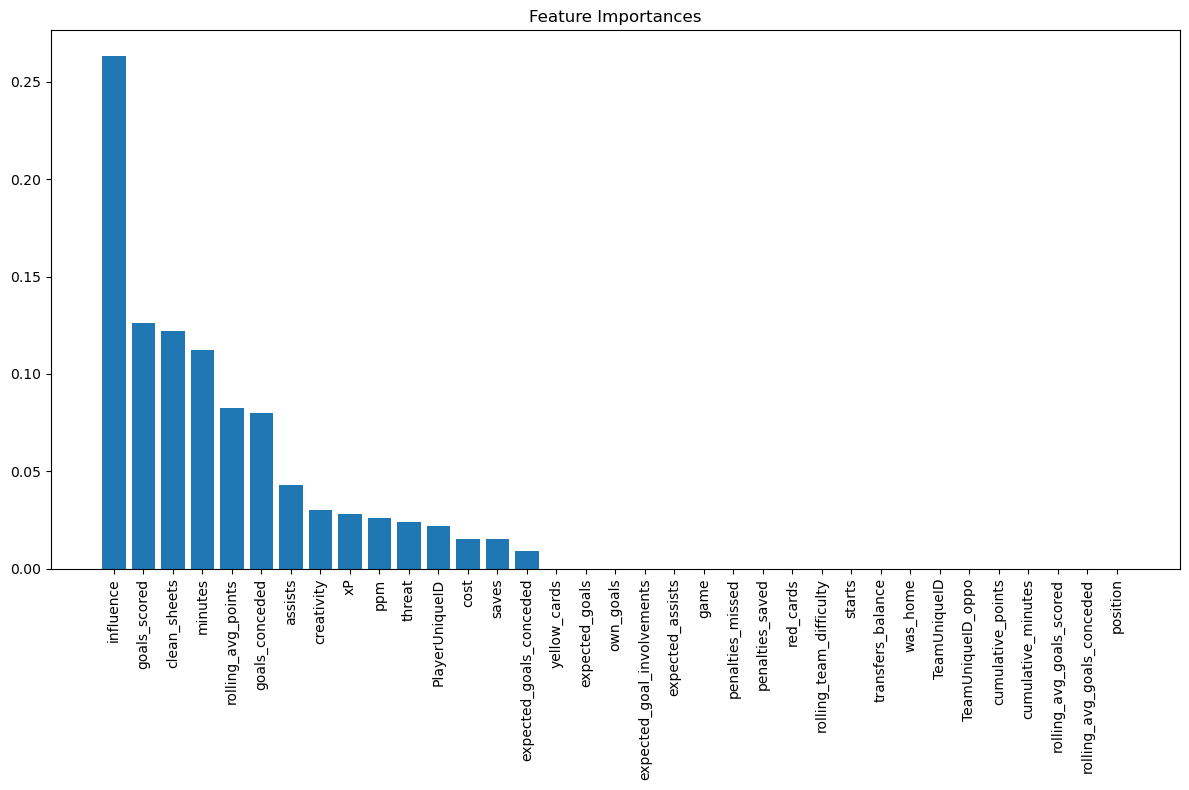

Model saved as FPL_XGboost_20241016.joblib


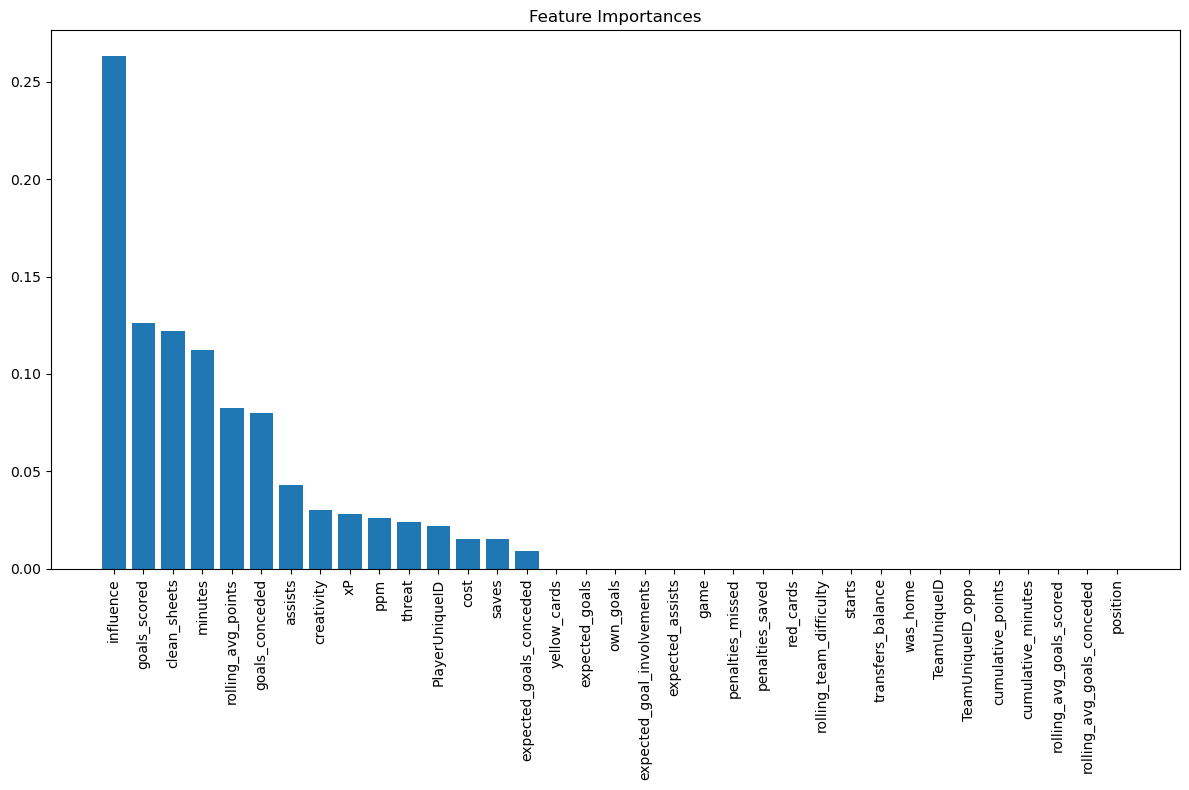

In [6]:
# Usage

#Start time
print("Start time:", datetime.now().strftime("%m-%d-%Y %H:%M:%S"))
#------

features = [
    'position', 'xP', 'assists', 'clean_sheets', 'creativity', 'expected_assists',
    'expected_goal_involvements', 'expected_goals', 'expected_goals_conceded', 'goals_conceded', 
    'goals_scored', 'influence', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved', 
    'red_cards', 'saves', 'starts', 'threat', 'transfers_balance', 'cost', 'was_home',
    'yellow_cards', 'PlayerUniqueID', 'TeamUniqueID', 'TeamUniqueID_oppo', 'cumulative_points',
    'cumulative_minutes', 'ppm', 'rolling_avg_points', 'rolling_avg_goals_scored', 
    'rolling_avg_goals_conceded', 'rolling_team_difficulty', 'game'
]
target = 'total_points'
current_season_games = ['20242501', '20242502', '20242503', '20242504', '20242505', '20242506', '20242507']
predictions, overall_mae, overall_r2, final_model = dynamic_model_training_with_updates(player_history, features, target, current_season_games)

# To load the model later
loaded_model = load_model(MODEL_NAME)

# To get feature importance of the loaded model
plot_feature_importance(loaded_model, features)

# Load Current Gameweek Data and run model


1. **Constants Definition**: The code begins by defining several constants, including URLs to raw player and fixture data, the current season, and the current game week (GW).

2. **Data Loading and Preprocessing**:
   - `load_and_preprocess_data()`: Loads player data, selects relevant columns, renames them, and calculates new metrics such as points per minute (ppm) and average minutes played.
   - `load_and_process_fixtures()`: Loads fixture data for the current game week.
   - `merge_player_and_fixture_data()`: Merges player data with fixture data for both home and away games, calculates transfers balance, cost, and whether the player was playing at home.

3. **Rolling Averages and Team Difficulty**:
   - `calculate_rolling_averages()`: Calculates rolling averages for team statistics.
   - `calculate_team_difficulty()`: Computes the average difficulty of teams based on their fixtures.

4. **Data Preparation for Prediction**:
   - `prepare_for_prediction()`: Merges player and team data, cleans up unnecessary columns, and calculates rolling averages and team difficulty.

5. **Data Type Conversion**:
   - `convert_dtypes_for_model()`: Converts specific columns to categorical data types for modeling.

6. **Advanced Metrics Calculation**:
   - `calculate_advanced_metrics()`: Computes expected goals (xG), expected assists (xA), and goal-scoring probability for players.

7. **Main Function** (commented out): The code includes a `main()` function that loads a pre-trained model, team, and player data, processes the data, and generates predictions for upcoming game weeks.

8. **Execution Block**: If the script is run as a main program, it executes the `main()` function and prints the top 20 players based on predicted points.

This section is structured to prepare and analyze fantasy football data, facilitating predictions based on player and team performance metrics.

In [7]:
# Constants in the cell below
# RAW_URL = 'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2024-25/players_raw.csv'
# FIXTURES_URL = 'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2024-25/fixtures.csv'
# CURRENT_SEASON = '2024-25'
# CURRENT_GW = 8
# GAME_ID = f'2024{CURRENT_GW:02d}'

def load_and_preprocess_data():
    # Load raw player data
    raw_2024_25 = pd.read_csv(RAW_URL)
    
    # Select and rename columns
    columns_to_select = [
        'element_type', 'ep_next', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
        'expected_assists', 'expected_goal_involvements', 'expected_goals', 'expected_goals_conceded',
        'goals_conceded', 'goals_scored', 'influence', 'minutes', 'own_goals', 'penalties_missed',
        'penalties_saved', 'red_cards', 'saves', 'selected_by_percent', 'starts', 'threat',
        'transfers_in', 'transfers_out', 'now_cost', 'yellow_cards', 'total_points',
        'points_per_game', 'team', 'team_code', 'first_name', 'second_name'
    ]
    columns_to_rename = {
        'element_type': 'position', 'ep_next': 'xP', 'now_cost': 'value',
        'minutes': 'cumulative_minutes', 'total_points': 'cumulative_points',
        'points_per_game': 'rolling_avg_points'
    }
    next_gw = raw_2024_25[columns_to_select].rename(columns=columns_to_rename)
    
    # Add game week info and calculate new columns
    next_gw['game'] = GAME_ID
    next_gw['ppm'] = next_gw['cumulative_points'] / next_gw['cumulative_minutes'].replace(0, 1)
    next_gw['minutes'] = next_gw['cumulative_minutes'] / (CURRENT_GW - 1)
    return next_gw

def load_and_process_fixtures():
    fixtures_2024_25 = pd.read_csv(FIXTURES_URL, usecols=['event', 'team_a', 'team_h', 'team_h_difficulty', 'team_a_difficulty'])
    return fixtures_2024_25[fixtures_2024_25['event'] == CURRENT_GW]

def merge_player_and_fixture_data(next_gw, fixtures):
    # Merge for both home and away teams
    merged_home = pd.merge(next_gw, fixtures, left_on='team', right_on='team_h', how='inner')
    merged_away = pd.merge(next_gw, fixtures, left_on='team', right_on='team_a', how='inner')
    final_merged_df = pd.concat([merged_home, merged_away])
    
    # Additional processing
    final_merged_df['transfers_balance'] = final_merged_df['transfers_in'] - final_merged_df['transfers_out']
    final_merged_df['cost'] = final_merged_df['value'] / 10
    final_merged_df['was_home'] = np.where(final_merged_df['team'] == final_merged_df['team_h'], 1, 0)
    return final_merged_df

def calculate_rolling_averages(df, window=5):
    # Sort the dataframe by team and game
    df = df.sort_values(['team', 'game'])
    
    # Calculate rolling averages for team-level statistics
    df['rolling_avg_goals_scored'] = df.groupby('team')['goals_scored'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    df['rolling_avg_goals_conceded'] = df.groupby('team')['goals_conceded'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    
    # Calculate rolling average points for individual players
    #df = df.sort_values(['PlayerUniqueID', 'game'])
    #df['rolling_avg_points'] = df.groupby('PlayerUniqueID')['total_points'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    
    return df

def calculate_team_difficulty(df):
    # Calculate average difficulty for each team
    team_difficulty = df.groupby('team')[['team_h_difficulty', 'team_a_difficulty']].mean().mean(axis=1)
    
    # Map team difficulty back to the dataframe
    df['rolling_team_difficulty'] = df['team'].map(team_difficulty)
    
    return df

def prepare_for_prediction(df, teams, players_unique, required_columns):
    # Merge with team data
    teams_new = teams[teams['season'] == CURRENT_SEASON]
    df = df.merge(teams_new, left_on='team', right_on='id', how='left')
    df = df.merge(teams_new, left_on='team_h', right_on='id', how='left', suffixes=('', '_oppo'))
    
    # Clean up columns
    columns_to_drop = ['id', 'id_oppo', 'team_name', 'team_name_oppo', 'season', 'season_oppo']
    df.drop(columns=columns_to_drop, errors='ignore', inplace=True)
    df.rename(columns={'TeamUniqueID': 'TeamUniqueID', 'TeamUniqueID_oppo': 'TeamUniqueID_oppo'}, inplace=True)
    
    # Merge with player data
    df = df.merge(players_unique, on=['first_name', 'second_name'], how='left')
    
    # Calculate rolling averages
    df = calculate_rolling_averages(df)
    
    # Calculate team difficulty
    df = calculate_team_difficulty(df)
    
    return df

def convert_dtypes_for_model(df, model_type):
    if df is None:
        # Handle the case where df is None
        return None  # Or raise an exception
    # Rest of the function remains unchanged
    category_columns = ['position', 'PlayerUniqueID', 'TeamUniqueID', 'TeamUniqueID_oppo', 'game']
    for col in category_columns:
        df[col] = df[col].astype('category')
    return df

def calculate_advanced_metrics(df):
    # Calculate expected goals (xG)
    # This is a simple placeholder logic; adjust according to your actual metric calculations
    df['expected_goals'] = (df['expected_goal_involvements'] * 0.6)  # Adjust this multiplier based on your model

    # Calculate expected assists (xA)
    df['expected_assists'] = df['expected_assists']  # xA directly from existing data

    # Calculate goal scoring probability as a percentage
    # Example calculation: if a player is expected to score a goal in a match based on their xG and minutes played
    # We'll use a more realistic multiplier for probability calculations
    df['goal_scoring_probability'] = (df['expected_goals'] / df['minutes'].replace(0, 1)) * 100
    df['goal_scoring_probability'] = df['goal_scoring_probability'].clip(0, 100)  # Ensure values are between 0 and 100

    return df

# If I want to run everything in one step uncomment and run else see the next cell
# def main():
#     # Load the trained model
#     loaded_model = joblib.load('latest_fpl_xgboost_model_with_updates_and_grid_search.joblib')
    
#     # Load team and player data (you need to implement these functions) - these are exported from above as teams and players_unique
#     #teams = load_team_data()
#     #players_unique = load_player_data()
    
#     # Define required columns based on your model's features
#     required_columns = [
#         'position', 'xP', 'assists', 'clean_sheets', 'creativity', 'expected_assists',
#     'expected_goal_involvements', 'expected_goals', 'expected_goals_conceded', 'goals_conceded', 
#     'goals_scored', 'influence', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved', 
#     'red_cards', 'saves', 'starts', 'threat', 'transfers_balance', 'cost', 'was_home',
#     'yellow_cards', 'PlayerUniqueID', 'TeamUniqueID', 'TeamUniqueID_oppo', 'cumulative_points',
#     'cumulative_minutes', 'ppm', 'rolling_avg_points', 'rolling_avg_goals_scored', 
#     'rolling_avg_goals_conceded', 'rolling_team_difficulty', 'game'
#     ]
    
#     next_gw = load_and_preprocess_data()
#     fixtures = load_and_process_fixtures()
#     final_merged_df = merge_player_and_fixture_data(next_gw, fixtures)
    
#     upcoming_game_week_data = prepare_for_prediction(final_merged_df, teams, players_unique, required_columns)
#     upcoming_game_week_data = convert_dtypes_for_model(upcoming_game_week_data, 'xgboost')
    
#     # Make predictions
#     predictions_upcoming = loaded_model.predict(upcoming_game_week_data[required_columns])
#     upcoming_game_week_data['predicted_points'] = predictions_upcoming
    
#     return upcoming_game_week_data

# if __name__ == "__main__":
#     result = main()
#     print(result.sort_values('predicted_points', ascending=False).head(20))

In [8]:
#Usage

# Constants
RAW_URL = 'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2024-25/players_raw.csv'
FIXTURES_URL = 'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2024-25/fixtures.csv'
CURRENT_SEASON = '2024-25'
CURRENT_GW = 8
GAME_ID = f'2024{CURRENT_GW:02d}'


# Load the trained model
loaded_model = joblib.load(MODEL_NAME)

# Load team and player data (you need to implement these functions) - these are exported from above as teams and players_unique
#teams = load_team_data()
#players_unique = load_player_data()

# Define required columns based on your model's features
required_columns = [
    'position', 'xP', 'assists', 'clean_sheets', 'creativity', 'expected_assists',
'expected_goal_involvements', 'expected_goals', 'expected_goals_conceded', 'goals_conceded', 
'goals_scored', 'influence', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved', 
'red_cards', 'saves', 'starts', 'threat', 'transfers_balance', 'cost', 'was_home',
'yellow_cards', 'PlayerUniqueID', 'TeamUniqueID', 'TeamUniqueID_oppo', 'cumulative_points',
'cumulative_minutes', 'ppm', 'rolling_avg_points', 'rolling_avg_goals_scored', 
'rolling_avg_goals_conceded', 'rolling_team_difficulty', 'game'
]

next_gw = load_and_preprocess_data()
fixtures = load_and_process_fixtures()
final_merged_df = merge_player_and_fixture_data(next_gw, fixtures)

upcoming_game_week_data = prepare_for_prediction(final_merged_df, teams, players_unique, required_columns)
upcoming_game_week_data = convert_dtypes_for_model(upcoming_game_week_data, 'xgboost')

upcoming_game_week_data = calculate_advanced_metrics(upcoming_game_week_data)

# Make predictions
predictions_upcoming = loaded_model.predict(upcoming_game_week_data[required_columns])
upcoming_game_week_data['predicted_points'] = predictions_upcoming

In [9]:
## NOTE ##
# Advanced Metrics are a work in progress and don't look all too accurate or correct. 

# Select Best Team

1. **Team Selection Optimization**:
   - **`optimize_team_selection(upcoming_game_week_data, budget=100)`**: This function uses linear programming to select an optimal team of players within a specified budget.
     - **Position Constraints**: It defines constraints for player positions (goalkeeper, defenders, midfielders, forwards) and their minimum and maximum counts.
     - **Objective Function**: The goal is to maximize the predicted points while adhering to the budget and positional constraints.
     - The function returns a selection of players (indicated by a binary array) based on the optimization results.

2. **Team Preparation**:
   - **`prepare_selected_team(upcoming_game_week_data, selected_players, teams)`**: This function prepares the final selected team by filtering for the chosen players and merging their data with team information.
     - It maps position codes to their text representations (e.g., GK, DEF) and formats other relevant columns for output.
     - The function returns a DataFrame containing details about the selected players, including their teams, positions, costs, and predicted points.

3. **Main Function**:
   - **`main(upcoming_game_week_data, teams, budget=100)`**: This function coordinates the selection and preparation of the optimized team by calling the previous two functions. It returns the final team lineup.

4. **Execution Block** (commented out): The code includes a section that would execute the `main()` function if the script is run as a standalone program, assuming the required data is already loaded.

Overall, the section is designed to optimize fantasy football team selections based on player performance predictions, budget constraints, and positional requirements.

In [10]:
def optimize_team_selection(upcoming_game_week_data, budget=100):
    # Constants and mappings
    POSITION_MAPPING = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
    POSITION_COUNTS = {
        'GK': (1, 2),
        'DEF': (3, 5),
        'MID': (3, 5),
        'FWD': (1, 3)
    }

    # Prepare data
    player_costs = upcoming_game_week_data['cost'].values
    player_points = upcoming_game_week_data['predicted_points'].values
    player_positions = upcoming_game_week_data['position'].values
    num_players = len(player_costs)

    # Objective function: maximize points (minimize negative points)
    c = -player_points

    # Constraints
    A = [player_costs]  # Budget constraint
    b = [budget]

    # Position constraints
    for pos, (min_count, max_count) in POSITION_COUNTS.items():
        pos_indicator = (player_positions == [k for k, v in POSITION_MAPPING.items() if v == pos][0]).astype(int)
        A.extend([pos_indicator, -pos_indicator])
        b.extend([max_count, -min_count])

    A = np.array(A)
    b = np.array(b)

    # Bounds for each player (0 or 1 - either selected or not)
    bounds = [(0, 1) for _ in range(num_players)]

    # Solve the linear programming problem
    result = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='highs')

    # Get the selected players
    selected_players = result.x.round().astype(int)

    return selected_players

def prepare_selected_team(upcoming_game_week_data, selected_players, teams):
    # Filter for selected players
    selected_team = upcoming_game_week_data[selected_players == 1].copy()

    # Merge with team data
    current_season_teams = teams[teams['season'] == '2024-25']
    selected_team = selected_team.merge(current_season_teams[['TeamUniqueID', 'team_name']], on='TeamUniqueID', how='left')
    selected_team = selected_team.merge(current_season_teams[['TeamUniqueID', 'team_name']], left_on='TeamUniqueID_oppo', right_on='TeamUniqueID', how='left', suffixes=('', '_oppo'))
    
    # Map position codes to text
    position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
    selected_team['position_txt'] = selected_team['position'].map(position_mapping)

    # Prepare output
    selected_team['was_home'] = selected_team['was_home'].apply(lambda x: 'H' if x == 1 else 'A')
    columns_to_display = ['team_name', 'name', 'position_txt', 'cost', 'predicted_points', 'team_name_oppo',
                          'was_home','expected_goals', 'expected_assists', 'goal_scoring_probability']

    selected_team = selected_team[columns_to_display].sort_values('predicted_points', ascending=False)

    selected_team.rename(columns={'team_name': 'Team', 'name':'Player', 'position_txt':'Position',
                                 'cost':'Player Cost', 'predicted_points':'Predicted Gameweek Points',
                                 'team_name_oppo':'Opposition Team Name', 'was_home':'Home or Away',
                                 'expected_goals':'Xg', 'expected_assists':'Xa',
                                 'goal_scoring_probability':'Goal Scoring Probability (%)'}, inplace=True)
    return selected_team

def main(upcoming_game_week_data, teams, budget=100):
    selected_players = optimize_team_selection(upcoming_game_week_data, budget)
    optimized_team = prepare_selected_team(upcoming_game_week_data, selected_players, teams)
    return optimized_team

# if __name__ == "__main__":
#     # Assuming upcoming_game_week_data and teams are already loaded
#     optimized_team = main(upcoming_game_week_data, teams)
#     print(optimized_team)

In [11]:
# Usage
optimized_team = main(upcoming_game_week_data, teams)
print(optimized_team)

           Team                        Player Position  Player Cost  \
2   Aston Villa                 Ollie Watkins      FWD          9.1   
4       Chelsea               Nicolas Jackson      FWD          7.9   
5       Chelsea                   Cole Palmer      MID         10.8   
7       Everton                 Dwight McNeil      MID          5.6   
10    Liverpool                 Mohamed Salah      MID         12.7   
13        Spurs               Brennan Johnson      MID          6.5   
1       Arsenal                   Kai Havertz      FWD          8.3   
11     Man City                 Mateo Kovačić      MID          5.5   
8     Leicester                  James Justin      DEF          4.5   
0       Arsenal  Gabriel dos Santos Magalhães      DEF          6.2   
14       Wolves               Rayan Aït-Nouri      DEF          4.4   
9     Liverpool               Ibrahima Konaté      DEF          5.2   
3     Brentford                Nathan Collins      DEF          4.5   
12    

In [12]:
# Save the selected team to a CSV file
optimized_team.to_csv('selected_team_20242508.csv', index=False)

In [13]:
#Create requirements file
!pip freeze > requirements.txt